In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/sample_submission.csv
/kaggle/input/dataset/test_identity.csv
/kaggle/input/dataset/train_identity.csv
/kaggle/input/dataset/test_transaction.csv
/kaggle/input/dataset/train_transaction.csv


In [2]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.4.2 imbalanced-learn==0.12.2

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 86.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [3]:
!pip install imblearn
!pip install mlflow
!pip install optbinning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
import shap
import mlflow
import mlflow.sklearn

from optbinning import OptimalBinning
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 53.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 85.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.9/213.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 56.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [4]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)

## Data Loading And Cleaning

In [5]:
import pandas as pd

# Load data
trans = pd.read_csv('/kaggle/input/dataset/train_transaction.csv')
ident = pd.read_csv('/kaggle/input/dataset/train_identity.csv')
# Merge on TransactionID
data = trans.merge(ident, on='TransactionID', how='left')

# Drop columns with >90% missing values
missing_frac = data.isnull().mean()
cols_to_drop = missing_frac[missing_frac > 0.90].index
data = data.drop(columns=cols_to_drop)

# Drop the TransactionID column
data = data.drop('TransactionID', axis=1)


## Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split

y = data['isFraud']
X = data.drop('isFraud', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


## Preprocessing and Feature Engineering

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class MissingValueFiller(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.numeric_cols = None
        self.categorical_cols = None
        self.medians = None

    def fit(self, X, y=None):
        numeric = X.select_dtypes(include=[np.number])
        categorical = X.select_dtypes(include=['object'])
        self.numeric_cols = numeric.columns.tolist()
        self.categorical_cols = categorical.columns.tolist()
        self.medians = numeric.median()
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.numeric_cols] = X_copy[self.numeric_cols].fillna(self.medians)
        X_copy[self.categorical_cols] = X_copy[self.categorical_cols].fillna('missing')
        return X_copy


In [8]:
class WoEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3):
        self.threshold = threshold
        self.woe_maps = {}
        self.large_cat = []

    def fit(self, X, y):
        categorical = X.select_dtypes(include=['object'])
        for col in categorical.columns:
            if categorical[col].nunique() > self.threshold:
                df = pd.DataFrame({'feature': X[col], 'target': y})
                cross = df.groupby(['feature', 'target']).size().unstack(fill_value=0)
                p1 = (cross.get(1, 0) + 0.5) / (y.sum() + 0.5)
                p0 = (cross.get(0, 0) + 0.5) / ((len(y) - y.sum()) + 0.5)
                self.woe_maps[col] = np.log(p1 / p0)
                self.large_cat.append(col)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.large_cat:
            X_copy[col] = X_copy[col].map(self.woe_maps[col]).fillna(0)
        return X_copy


In [9]:
import shap
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class AutoSHAPFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, model_class, model_params=None, threshold=0.95):
        self.model_class = model_class
        self.model_params = model_params if model_params is not None else {}
        self.threshold = threshold
        self.selected_features_idx = None

    def fit(self, X, y):
        # Train a lightweight model internally
        model = self.model_class(**self.model_params)
        model.fit(X, y)

        # Compute SHAP values
        import shap
        explainer = shap.TreeExplainer(model, X, feature_perturbation="interventional", 
                                check_additivity=False, approximate=True)
        shap_values = explainer(X).values[1]

        # Calculate mean absolute SHAP values
        importance = np.abs(shap_values).mean(0)
        importance_df = pd.DataFrame({
            "feature_idx": np.arange(X.shape[1]),
            "importance": importance
        }).sort_values("importance", ascending=False)

        # Cumulative importance
        importance_df["cumulative"] = importance_df["importance"].cumsum() / importance_df["importance"].sum()

        # Select features
        self.selected_features_idx = importance_df[importance_df["cumulative"] <= self.threshold]["feature_idx"].tolist()
        return self

    def transform(self, X):
        return X[:, self.selected_features_idx]

    def get_feature_names_out(self, input_features=None):
        if input_features is not None:
            return [input_features[idx] for idx in self.selected_features_idx]
        else:
            return None

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np

class SimplePreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Initialize attributes during fit
        self.numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        cat_candidates = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
        self.cat_cols = [col for col in cat_candidates if X[col].nunique() <= 3]

        if self.numeric_cols:
            self.scaler = StandardScaler()
            self.scaler.fit(X[self.numeric_cols])
        else:
            self.scaler = None

        if self.cat_cols:
            self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            self.encoder.fit(X[self.cat_cols])
        else:
            self.encoder = None

        return self

    def transform(self, X):
        expected_cols = set(self.numeric_cols + self.cat_cols)
        input_cols = set(X.columns.tolist())
        missing = expected_cols - input_cols
        extra = input_cols - expected_cols
        if missing:
            raise ValueError(f"Missing expected columns: {missing}")
        if extra:
            raise ValueError(f"Unexpected columns in input: {extra}")

        if self.numeric_cols:
            num_arr = self.scaler.transform(X[self.numeric_cols])
        else:
            num_arr = np.empty((len(X), 0))

        if self.cat_cols:
            cat_arr = self.encoder.transform(X[self.cat_cols])
        else:
            cat_arr = np.empty((len(X), 0))

        return np.hstack([num_arr, cat_arr])


## Pipeline Construction

In [15]:
RANDOM_STATE = 42

from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline

pipeline = Pipeline([
    ('undersampler', RandomUnderSampler(sampling_strategy=0.2, random_state=42)),
    ('missing', MissingValueFiller()),
    ('woe', WoEEncoder(threshold=3)),
    ('preprocessor', SimplePreprocessor()),
    ('classifier', RandomForestClassifier(n_jobs=-1,random_state=42,oob_score=True))
])

## Hyperparameter Tuning

In [17]:
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=0.2, random_state=42)

In [13]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=2, shuffle=True, random_state=42)

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid_md = {'classifier__max_depth': [10, 15, 20]}
grid_search_md = GridSearchCV(
    pipeline, param_grid=param_grid_md, 
    scoring='roc_auc', cv=kfold, n_jobs=-1
)
grid_search_md.fit(X_sample, y_sample)

best_max_depth = grid_search_md.best_params_['classifier__max_depth']
print(f"Best max_depth: {best_max_depth}")

pipeline.set_params(classifier__max_depth=best_max_depth)

Best max_depth: 20


Pipeline(steps=[('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.2)),
                ('missing', MissingValueFiller()), ('woe', WoEEncoder()),
                ('preprocessor', SimplePreprocessor()),
                ('classifier',
                 RandomForestClassifier(max_depth=20, n_jobs=-1, oob_score=True,
                                        random_state=42))])

In [20]:
param_grid_ne = {'classifier__n_estimators': [100, 200 , 300, 500]}
grid_search_ne = GridSearchCV(
    pipeline, param_grid=param_grid_ne,
    cv=kfold, scoring='roc_auc', n_jobs=-1, verbose=1
)
grid_search_ne.fit(X_sample, y_sample)

best_n_estimators = grid_search_ne.best_params_['classifier__n_estimators']
print(f"Best n_estimators: {best_n_estimators}")

# Update pipeline with best n_estimators
pipeline.set_params(classifier__n_estimators=best_n_estimators)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best n_estimators: 500


Pipeline(steps=[('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.2)),
                ('missing', MissingValueFiller()), ('woe', WoEEncoder()),
                ('preprocessor', SimplePreprocessor()),
                ('classifier',
                 RandomForestClassifier(max_depth=20, n_estimators=500,
                                        n_jobs=-1, oob_score=True,
                                        random_state=42))])

In [21]:
param_grid_mss = {'classifier__min_samples_split': [2, 5 , 10, 20]}
grid_search_mss = GridSearchCV(
    pipeline, param_grid=param_grid_mss,
    cv=kfold, scoring='roc_auc', n_jobs=-1, verbose=1
)
grid_search_mss.fit(X_sample, y_sample)

best_min_samples_split = grid_search_mss.best_params_['classifier__min_samples_split']
print(f"Best n_estimators: {best_min_samples_split}")

# Update pipeline with best n_estimators
pipeline.set_params(classifier__min_samples_split=best_min_samples_split)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best n_estimators: 2


Pipeline(steps=[('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.2)),
                ('missing', MissingValueFiller()), ('woe', WoEEncoder()),
                ('preprocessor', SimplePreprocessor()),
                ('classifier',
                 RandomForestClassifier(max_depth=20, n_estimators=500,
                                        n_jobs=-1, oob_score=True,
                                        random_state=42))])

In [22]:
param_grid_msl = {'classifier__min_samples_leaf': [2, 5 , 10, 20]}
grid_search_msl = GridSearchCV(
    pipeline, param_grid=param_grid_msl,
    cv=kfold, scoring='roc_auc', n_jobs=-1, verbose=1
)
grid_search_msl.fit(X_sample, y_sample)

best_min_samples_leaf = grid_search_msl.best_params_['classifier__min_samples_leaf']
print(f"Best min_samples_leaf: {best_min_samples_leaf}")

# Update pipeline with best n_estimators
pipeline.set_params(classifier__min_samples_leaf=best_min_samples_leaf)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best min_samples_leaf: 2


Pipeline(steps=[('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.2)),
                ('missing', MissingValueFiller()), ('woe', WoEEncoder()),
                ('preprocessor', SimplePreprocessor()),
                ('classifier',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=2,
                                        n_estimators=500, n_jobs=-1,
                                        oob_score=True, random_state=42))])

## Model Evaluation

In [23]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.2)),
                ('missing', MissingValueFiller()), ('woe', WoEEncoder()),
                ('preprocessor', SimplePreprocessor()),
                ('classifier',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=2,
                                        n_estimators=500, n_jobs=-1,
                                        oob_score=True, random_state=42))])

=== TRAIN SET REPORT ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    455902
           1       0.77      0.66      0.71     16530

    accuracy                           0.98    472432
   macro avg       0.88      0.83      0.85    472432
weighted avg       0.98      0.98      0.98    472432

Train Acc:   0.9810
Train Prec:  0.7653
Train Rec:   0.6607
Train F1:    0.7092
Train AUC:   0.9507

=== TEST SET REPORT ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113975
           1       0.69      0.55      0.61      4133

    accuracy                           0.98    118108
   macro avg       0.84      0.77      0.80    118108
weighted avg       0.97      0.98      0.97    118108

Test Acc:   0.9756
Test Prec:  0.6892
Test Rec:   0.5509
Test F1:    0.6123
Test AUC:   0.9179


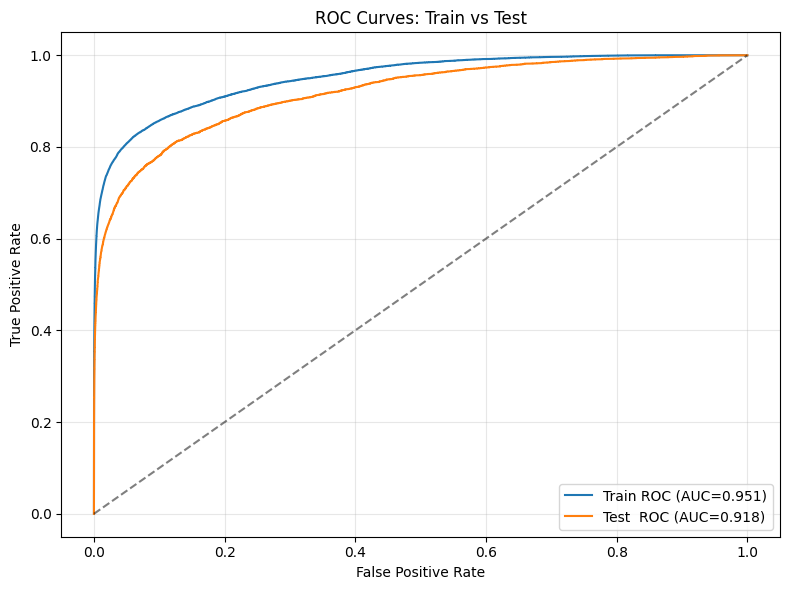

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report
)

best_model = pipeline

# assume `best_model` is already fitted (pipeline or grid.best_estimator_)
# 1) TRAIN METRICS
y_train_pred  = best_model.predict(X_train)
y_train_score = best_model.predict_proba(X_train)[:,1]

print("=== TRAIN SET REPORT ===")
print(classification_report(y_train, y_train_pred))

train_acc   = accuracy_score(y_train, y_train_pred)
train_prec  = precision_score(y_train, y_train_pred)
train_rec   = recall_score(y_train, y_train_pred)
train_f1    = f1_score(y_train, y_train_pred)
train_auc   = roc_auc_score(y_train, y_train_score)

print(f"Train Acc:   {train_acc:.4f}")
print(f"Train Prec:  {train_prec:.4f}")
print(f"Train Rec:   {train_rec:.4f}")
print(f"Train F1:    {train_f1:.4f}")
print(f"Train AUC:   {train_auc:.4f}")

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_score)

# 2) TEST METRICS
y_test_pred  = best_model.predict(X_test)
y_test_score = best_model.predict_proba(X_test)[:,1]

print("\n=== TEST SET REPORT ===")
print(classification_report(y_test, y_test_pred))

test_acc   = accuracy_score(y_test, y_test_pred)
test_prec  = precision_score(y_test, y_test_pred)
test_rec   = recall_score(y_test, y_test_pred)
test_f1    = f1_score(y_test, y_test_pred)
test_auc   = roc_auc_score(y_test, y_test_score)

print(f"Test Acc:   {test_acc:.4f}")
print(f"Test Prec:  {test_prec:.4f}")
print(f"Test Rec:   {test_rec:.4f}")
print(f"Test F1:    {test_f1:.4f}")
print(f"Test AUC:   {test_auc:.4f}")

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_score)

# 3) PLOT BOTH ROC CURVES OVERLAID
plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC={train_auc:.3f})")
plt.plot(fpr_test,  tpr_test,  label=f"Test  ROC (AUC={test_auc:.3f})")
plt.plot([0,1],[0,1],"k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Train vs Test")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("roc_train_vs_test.png")
plt.show()


## Logging on MlFlow

In [26]:
!pip install dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: graphql-core
    Found existing installation: graphql-core 3.2.6
    Uninstalling graphql-core-3.2.6:
      Successfully uninstalled graphql-core-3.2.6
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
      Successfully uninstalled dacite-1.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires dacite>=1.8, but you have dacite 1.6.0 which is incompatible.


In [28]:
import dagshub
dagshub.init(repo_owner='losaberidzebadri', repo_name='IEEE-CIS-Fraud-Detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=8da66443-c51d-48d7-b709-412713e8969c&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=c13bfc0a3cde88d8ed06d5eda81f120362f2adf2a30303ac7c6096aded915459




Accessing as losaberidzebadri

Initialized MLflow to track repo "losaberidzebadri/IEEE-CIS-Fraud-Detection"

Repository losaberidzebadri/IEEE-CIS-Fraud-Detection initialized!

In [30]:
import mlflow
import mlflow.sklearn

mlflow.set_experiment("RandomForestClassifierTraining")

with mlflow.start_run(run_name="RandomForestClassifier_FinalModelEval"):
    # log params…
    mlflow.log_param("max_depth", best_max_depth) 
    mlflow.log_param("min_samples_split", best_min_samples_split)
    mlflow.log_param("n_estimators", best_n_estimators)
    mlflow.log_param("min_samples_leaf", best_min_samples_leaf)
    
    # log train metrics
    mlflow.log_metric("train_accuracy",   train_acc)
    mlflow.log_metric("train_precision",  train_prec)
    mlflow.log_metric("train_recall",     train_rec)
    mlflow.log_metric("train_f1",         train_f1)
    mlflow.log_metric("train_auc",        train_auc)
    # log test metrics
    mlflow.log_metric("test_accuracy",    test_acc)
    mlflow.log_metric("test_precision",   test_prec)
    mlflow.log_metric("test_recall",      test_rec)
    mlflow.log_metric("test_f1",          test_f1)
    mlflow.log_metric("test_auc",         test_auc)
    # log the ROC plot
    mlflow.log_artifact("roc_train_vs_test.png")
    # log the model itself
    mlflow.sklearn.log_model(best_model, "final_model")


2025/04/27 20:04:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_FinalModelEval at: https://dagshub.com/losaberidzebadri/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2/runs/05526a2725f5433da2a78e806a10099b
🧪 View experiment at: https://dagshub.com/losaberidzebadri/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2
